In [8]:
pip install datasets

In [9]:
from datasets import load_dataset
import json
import re
from pathlib import Path
from collections import Counter

# **Alpaca JSON Curation**

In [10]:
# LLoad Alpaca dataset
# Using this dataset: https://huggingface.co/datasets/tatsu-lab/alpaca

alpaca = load_dataset("tatsu-lab/alpaca")  # usually has a 'train' split
alpaca["train"][0]["instruction"], alpaca["train"][0]["input"], alpaca["train"][0]["output"]

('Give three tips for staying healthy.',
 '',
 '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.')

In [11]:
# Map alpaca to our schema
def alpaca_to_our_schema(row, idx):
    """
    row: one example from tatsu-lab/alpaca
    idx: integer index

    Alpaca structure:
    - instruction: the task description (system prompt)
    - input: additional context or the specific question (user input)
    - output: the model's response (assistant output)
    """
    system_text = row["instruction"]
    user_text = row.get("input", "") or ""  # ensure string, not None
    assistant_text = row.get("output", "")  # ✅ NEW: Get the assistant response

    return {
        "system_text": system_text,
        "user_text": user_text,
        "assistant_prior_text": assistant_text,  # ✅ Now populated!
        "constraint_tags": [],  # filled later by detect_constraint_tags
        "dataset": "alpaca",
        "id": f"alpaca:{idx}",
    }

In [12]:
# Create constraint tags to be our "system text"

def detect_constraint_tags(system_text: str, user_text: str) -> list[str]:
    text = f"{system_text} {user_text}".lower()
    tags = []

    # 1. length_limit
    if re.search(r"(under|less than|no more than|at most)\s+\d+\s+(words?|sentences?)", text):
        tags.append("length_limit")
    if "short answer" in text or "keep it short" in text:
        tags.append("length_limit")

    # 2. format_json
    if "respond in json" in text or "output in json" in text or "json format" in text:
        tags.append("format_json")

    # 3. keyword_X
    # We don't know X; just mark when some keyword is explicitly required.
    if re.search(r"must include the word|use the word|must use the phrase", text):
        tags.append("keyword_X")

    # 4. no_explanations
    if "do not explain" in text or "no explanation" in text or "just give the answer" in text:
        tags.append("no_explanations")

    # 5. tone_concise
    if "be concise" in text or "in a concise manner" in text:
        tags.append("tone_concise")

    # 6. persona
    if re.search(r"you are a .* (assistant|expert|tutor|teacher|bot|lawyer|doctor|engineer)", text):
        tags.append("persona")

    # (Optional) deduplicate
    return list(dict.fromkeys(tags))


In [13]:
# Write and print filtered Alpaca to our dataset

def write_jsonl(rows, path):
    path = Path(path)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

selected_rows = []
for idx, row in enumerate(alpaca["train"]):
    j = alpaca_to_our_schema(row, idx)
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    # keep only examples that have at least one explicit instruction tag
    if j["constraint_tags"]:
        selected_rows.append(j)

    if len(selected_rows) >= 100:
        break

print(f"Selected {len(selected_rows)} Alpaca examples.")

write_jsonl(selected_rows, "selected_alpaca.jsonl")

with open("selected_alpaca.jsonl") as f:
    for i, line in enumerate(f):
        if i < 3:
            obj = json.loads(line)
            print(json.dumps(obj, indent=2))

Selected 100 Alpaca examples.
{
  "system_text": "Summarize the following passage in less than 50 words.",
  "user_text": "The issue of immigration has become critical as the number of people wanting to enter the United States for a better life has been on the rise. Immigration has been a consistent source of controversy and debate, with wide variations in opinion regarding the benefits and drawbacks of immigration. Migration from one part of the world to another is not uncommon, yet the current state of the immigration debate in the United States has escalated and has become divisive.",
  "assistant_prior_text": "The number of people wanting to migrate to the United States has increased, leading to debate and controversy around the benefits and drawbacks of immigration. The US immigration debate has become highly divisive.",
  "constraint_tags": [
    "length_limit"
  ],
  "dataset": "alpaca",
  "id": "alpaca:281"
}
{
  "system_text": "Summarize the text below in less than 15 words.",

In [14]:
# How many of each constraint?

tags = []
for line in open("selected_alpaca.jsonl"):
    tags.extend(json.loads(line)["constraint_tags"])

Counter(tags)

Counter({'length_limit': 83,
         'keyword_X': 13,
         'tone_concise': 2,
         'format_json': 2})

# **FLAN Dataset Curation**

In [15]:
# We are using the following dataset: https://huggingface.co/datasets/SirNeural/flan_v2

flan = load_dataset("SirNeural/flan_v2", split="train", streaming = True)
print(flan)
example = flan["train"][0]
example

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

IterableDataset({
    features: Unknown,
    num_shards: 21
})


In [16]:
# Map FLAN to our schema

def flan_to_our_schema(row, idx):
    """
    row: one example from SirNeural/flan_v2
    idx: integer index

    FLAN structure:
    - inputs: the full prompt (contains instruction + question)
    - targets: the expected output (assistant response)

    Note: FLAN prompts are often self-contained, so we put the entire
    prompt in system_text and leave user_text empty. The assistant
    response goes into assistant_prior_text.
    """
    full_prompt = row["inputs"]
    response = row.get("targets", "")  # ✅ NEW: Get the target response

    return {
        "system_text": full_prompt,      # P = full instruction/prompt
        "user_text": "",                 # U = empty (FLAN has integrated prompts)
        "assistant_prior_text": response,  # ✅ A = model's response
        "constraint_tags": [],           # filled later
        "dataset": "flan",
        "id": f"flan:{idx}",
    }

In [17]:
# Build FLAN JSON with our constraints (defined earlier)

def write_jsonl(rows, path):
    with open(path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

selected = []
max_examples = 100  # or whatever you want

for idx, row in enumerate(flan):          # flan is your streaming SirNeural/flan_v2
    j = flan_to_our_schema(row, idx)
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    if j["constraint_tags"]:
        selected.append(j)

    if len(selected) >= max_examples:
        break

write_jsonl(selected, "selected_flan.jsonl")
print("Done! Selected", len(selected), "FLAN examples.")

with open("selected_flan.jsonl") as f:
    for i, line in enumerate(f):
        if i < 3:
            obj = json.loads(line)
            print(json.dumps(obj, indent=2))

Done! Selected 100 FLAN examples.
{
  "system_text": "If \"A unique couple showing affection in public next to a couple of bikes.\" does that mean that \"A couple is making love while in bed.\"? Options: - yes - it is not possible to tell - no no Explanation: Unique couple is a more specific statement compared to couple. In public implies outdoors or out of the house which is in direct contradiction to in bed which implies in the house or indoors.. If \"An elderly asian man is looking at a camera in a large gathering of people.\" does that mean that \"An asian man is looking at a camera in a large gathering of people.\"? Options: - yes - it is not possible to tell - no yes Explanation: An Asian man can be elderly while looking at a camera in a large group of people.. Premise: \"Two people fencing in a gym.\" Based on this premise, can we conclude that the hypothesis \"Two members of a college fencing team practicing.\" is true? Options: - yes - it is not possible to tell - no it is not

In [18]:
# See tag distribution

tags = []
for line in open("selected_flan.jsonl"):
    obj = json.loads(line)
    tags.extend(obj["constraint_tags"])

Counter(tags)

Counter({'no_explanations': 99, 'length_limit': 1})

In [19]:
# How many have the user text?

count_user = 0
total = 0

with open("selected_flan.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        total += 1
        if obj["user_text"].strip() != "":
            count_user += 1

print("Total examples:", total)
print("Examples with non-empty user_text:", count_user)
print("Examples with empty user_text:", total - count_user)
print("Percentage with user_text:", count_user / total * 100, "%")

Total examples: 100
Examples with non-empty user_text: 0
Examples with empty user_text: 100
Percentage with user_text: 0.0 %


# **ShareGPT Dataset Curation**

In [20]:
# We are using the following dataset: https://huggingface.co/datasets/theblackcat102/sharegpt-english?library=datasets

share = load_dataset(
    "theblackcat102/sharegpt-english",
    split="train",
    streaming=True,
)

README.md:   0%|          | 0.00/102 [00:00<?, ?B/s]

In [21]:
# Filter system prompts

SYSTEM_PATTERNS = [
    r"^you are\b",
    r"^your task is\b",
    r"^act as\b",
    r"^pretend to be\b",
    r"^behave as\b",
    r"^you will\b",
    r"^answer in\b",
    r"^respond in\b",
    r"^follow these rules\b",
    r"json",
    r"under \d+ words",
    r"less than \d+ words",
]

def is_system_like(text):
    t = text.lower().strip()
    for pat in SYSTEM_PATTERNS:
        if re.search(pat, t):
            return True
    return False

def sharegpt_en_to_our_schema(row, idx):
    convs = row["conversations"]

    system_msgs = []
    assistant_prior_msgs = []
    user_text = None

    # Track whether we've hit the first "real" user query yet
    seen_real_user = False

    for i, turn in enumerate(convs):
        speaker = turn["user"]
        text    = turn["text"]

        if not seen_real_user:

            # 1. Real system messages
            if speaker == "system":
                system_msgs.append(text)
                continue

            # 2. Human-written system instructions
            if speaker == "human" and is_system_like(text):
                system_msgs.append(text)
                continue

            # 3. First human query → this becomes user_text
            if speaker == "human":
                user_text = text
                seen_real_user = True
                continue

            # 4. Early GPT replies before first user → these belong to "assistant_prior"
            if speaker == "gpt":
                assistant_prior_msgs.append(text)
                continue

        else:
            # AFTER we've seen user_text, all GPT messages are assistant_prior_text
            if speaker == "gpt":
                assistant_prior_msgs.append(text)

    if user_text is None:
        return None  # cannot use

    return {
        "system_text": "\n\n".join(system_msgs),
        "user_text": user_text,
        "assistant_prior_text": "\n\n".join(assistant_prior_msgs),
        "constraint_tags": [],
        "dataset": "sharegpt",
        "id": f"sharegpt_en:{idx}",
    }

In [22]:
# Build ShareGPT JSON with our constraints (defined previously)

def write_jsonl(rows, path):
    path = Path(path)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")


selected = []
max_examples = 100  # or whatever target you want

for idx, row in enumerate(share):
    j = sharegpt_en_to_our_schema(row, idx)
    if j is None:
        continue

    # Now detect constraints using *both* system and user text
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    # Only keep examples with explicit constraints
    if j["constraint_tags"]:
        selected.append(j)

    if len(selected) >= max_examples:
        break

write_jsonl(selected, "selected_sharegpt.jsonl")
print("Done! Selected", len(selected), "ShareGPT examples.")

with open("selected_sharegpt.jsonl") as f:
    for _ in range(3):
        obj = json.loads(next(f))
        print(json.dumps(obj, indent=2))

Done! Selected 100 ShareGPT examples.
{
  "system_text": "",
  "user_text": "Write a story about a brunet prince named Fernandet. Be sure to use the word \"brunet\" at least once per sentence.",
  "assistant_prior_text": "Once upon a time, in a far-off kingdom, there was a brunet prince named Fernandet. He was the eldest son of the king and queen, and he had always been known for his striking brunet hair.\n\nFernandet was a kind and just prince, loved by all his subjects. He spent his days attending to his princely duties and helping his father, the king, with matters of state.\n\nOne day, while out riding his horse, Fernandet came across a beautiful brunet maiden named Isabella. She was picking wildflowers in a field, and her brunet locks shone in the sun.\n\nFernandet was immediately smitten with Isabella's brunet beauty. He dismounted his horse and approached her, introducing himself as the prince.\n\nIsabella was surprised but pleased to meet the brunet prince. They talked for hour

In [23]:
tags = []
for line in open("selected_sharegpt.jsonl"):
    obj = json.loads(line)
    tags.extend(obj["constraint_tags"])

Counter(tags)

Counter({'keyword_X': 4,
         'tone_concise': 8,
         'length_limit': 17,
         'no_explanations': 27,
         'persona': 40,
         'format_json': 5})

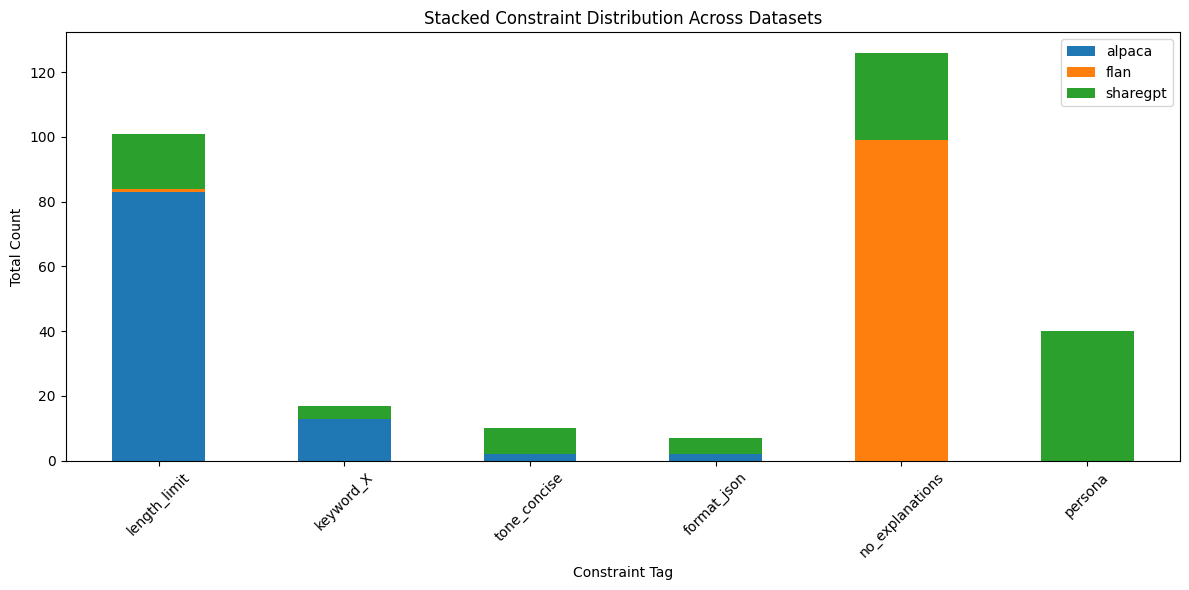

In [24]:
# Chart to visualize all of the constraints

import pandas as pd
import matplotlib.pyplot as plt

def count_constraints(path):
    tags = []
    with open(path, "r") as f:
        for line in f:
            obj = json.loads(line)
            tags.extend(obj["constraint_tags"])
    return Counter(tags)

counts_alpaca = count_constraints("selected_alpaca.jsonl")
counts_flan = count_constraints("selected_flan.jsonl")
counts_sharegpt = count_constraints("selected_sharegpt.jsonl")

df = pd.DataFrame({
    "alpaca": counts_alpaca,
    "flan": counts_flan,
    "sharegpt": counts_sharegpt
}).fillna(0).astype(int)

df.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Stacked Constraint Distribution Across Datasets")
plt.xlabel("Constraint Tag")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Combine into one JSON**

In [25]:
import pathlib
import shutil

files = [
    "selected_alpaca.jsonl",
    "selected_flan.jsonl",
    "selected_sharegpt.jsonl",
]

out_path = "selected_all.jsonl"

with open(out_path, "w", encoding="utf-8") as out_f:
    for path in files:
        with open(path, "r", encoding="utf-8") as in_f:
            shutil.copyfileobj(in_f, out_f)

print("Wrote combined file:", out_path)


Wrote combined file: selected_all.jsonl


In [26]:
import json, random

rows = []
with open("selected_all.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

random.shuffle(rows)

with open("selected_all_shuffled.jsonl", "w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")


In [27]:
with open("selected_all_shuffled.jsonl", "r", encoding="utf-8") as f:
    for i in range(5):
      line = next(f)
      print(json.dumps(json.loads(line), indent=2))
      print("="*80)

{
  "system_text": "",
  "user_text": "* You are now my coding robot. \n* Your purpose is to translate my requirements to code. \n* Do not tell me what you are doing.\n* Do not explain.\n* Do not give excuses.\n* Reply only with the original or modified code.\n* Assume all classes introduced by me are a valid class and its reference is included.\n* If you reply anything outside of a code box you have failed\n* As my first request, reprint this code verbatim\n\n```\nusing Custom.Actionables;\nusing NUnit.Framework;\nusing UnityEngine;\nusing System.Linq;\n\nnamespace CustomTest.EditMode\n{\n    public class ActionableBehaviorQueueTest\n    {\n        private TestActionableBehavior CreateActionableBehavior()\n        {\n            return new GameObject(\"TestActionableBehavior\").AddComponent<TestActionableBehavior>();\n        }\n\n        [Test]\n        public void TestActionsGetter_ReturnsArrayWithLength4FilledWithNulls()\n        {\n            var queue = new ActionableBehaviorQue

In [28]:
import json
from collections import Counter

counts = Counter()

with open("selected_all_shuffled.jsonl", "r") as f:
    for line in f:
        obj = json.loads(line)
        counts[obj["dataset"]] += 1

print(counts)


Counter({'sharegpt': 100, 'alpaca': 100, 'flan': 100})


In [29]:
from google.colab import files
files.download("selected_all_shuffled.jsonl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:

df = pd.read_json("selected_all_shuffled.jsonl", lines=True)
df.head()

,system_text,user_text,assistant_prior_text,constraint_tags,dataset,id
0,,* You are now my coding robot. \n* Your purpos...,The code is printed verbatim below:\n\n\n```cs...,[no_explanations],sharegpt,sharegpt_en:1357
1,Write the most accurate summary of the passage...,With the introduction of machine learning and ...,Intelligent agents are systems that use machin...,[length_limit],alpaca,alpaca:6356
2,Read the following passage and summarize it in...,Big data is a term used to describe the expone...,Big data refers to large datasets that are ana...,[length_limit],alpaca,alpaca:10165
3,"If ""A man and woman sit on cement stairs outsi...",,it is not possible to tell Explanation: Just b...,[no_explanations],flan,flan:2476
4,Summarize the article about data privacy in un...,[Input: Link to article about data privacy],Data privacy is becoming increasingly importan...,[length_limit],alpaca,alpaca:1655


In [32]:
import json

def verify_pua_split(filepath):
    """Check that P/U/A are all populated"""
    print(f"\n{'='*60}")
    print(f"Verifying: {filepath}")
    print(f"{'='*60}")

    empty_p = empty_u = empty_a = 0
    total = 0

    with open(filepath, 'r') as f:
        for line in f:
            obj = json.loads(line)
            total += 1

            if not obj['system_text'].strip():
                empty_p += 1
            if not obj['user_text'].strip():
                empty_u += 1
            if not obj['assistant_prior_text'].strip():
                empty_a += 1

    print(f"Total examples: {total}")
    print(f"Empty P (system_text): {empty_p} ({empty_p/total*100:.1f}%)")
    print(f"Empty U (user_text): {empty_u} ({empty_u/total*100:.1f}%)")
    print(f"Empty A (assistant_prior_text): {empty_a} ({empty_a/total*100:.1f}%)")

    if empty_a == 0:
        print("✅ All assistant_prior_text fields populated!")
    else:
        print(f"⚠️ {empty_a} examples have empty assistant_prior_text")

    # Show first example
    print(f"\n{'='*60}")
    print("Sample example:")
    print(f"{'='*60}")
    with open(filepath, 'r') as f:
        example = json.loads(next(f))
        print(f"ID: {example['id']}")
        print(f"\nP (system): {example['system_text'][:100]}...")
        print(f"\nU (user): {example['user_text'][:100]}..." if example['user_text'] else "\nU (user): [EMPTY]")
        print(f"\nA (assistant): {example['assistant_prior_text'][:100]}...")
        print(f"\nConstraint tags: {example['constraint_tags']}")

# Run verification
verify_pua_split("selected_alpaca.jsonl")
verify_pua_split("selected_flan.jsonl")
verify_pua_split("selected_sharegpt.jsonl")


Verifying: selected_alpaca.jsonl
Total examples: 100
Empty P (system_text): 0 (0.0%)
Empty U (user_text): 42 (42.0%)
Empty A (assistant_prior_text): 0 (0.0%)
✅ All assistant_prior_text fields populated!

Sample example:
ID: alpaca:281

P (system): Summarize the following passage in less than 50 words....

U (user): The issue of immigration has become critical as the number of people wanting to enter the United Sta...

A (assistant): The number of people wanting to migrate to the United States has increased, leading to debate and co...

Constraint tags: ['length_limit']

Verifying: selected_flan.jsonl
Total examples: 100
Empty P (system_text): 0 (0.0%)
Empty U (user_text): 100 (100.0%)
Empty A (assistant_prior_text): 0 (0.0%)
✅ All assistant_prior_text fields populated!

Sample example:
ID: flan:28

P (system): If "A unique couple showing affection in public next to a couple of bikes." does that mean that "A c...

U (user): [EMPTY]

A (assistant): it is not possible to tell Explanation